In [ ]:
import math
import pypoman
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import os
import random
from scipy.stats import bernoulli, uniform, chi2
import numpy as np
from scipy.stats.mstats import gmean
from numpy.testing import assert_allclose
from iteround import saferound
from utils import Bets, Allocations, Weights, mart, lower_confidence_bound, global_lower_bound,\
    intersection_mart, plot_marts_eta, construct_eta_grid, union_intersection_mart, selector,\
    construct_eta_grid_plurcomp, construct_vertex_etas, simulate_comparison_audit, random_truncated_gaussian,\
    PGD, negexp_ui_mart, stratified_t_test
#np.random.seed(123456789)
np.random.seed(1337)

## Run UI-TS for a range of settings (a pared down version of the point-mass simulation script)

In [9]:
%%time 

#alt_grid = np.linspace(0.51, 0.75, 3)
alt_grid = [0.55]
delta_grid = [0.5]
alpha = 0.05
eta_0 = 0.5

methods_list = ['uinnsm_product']
bets_dict = {
    "fixed":Bets.fixed,
    "agrapa":lambda x, eta: Bets.agrapa(x, eta, c = 0.95)}
bets_list = ["fixed","agrapa"]
allocations_dict = {
    "round_robin":Allocations.round_robin,
    "predictable_kelly":Allocations.predictable_kelly,
    "greedy_kelly":Allocations.greedy_kelly}
allocations_list = ["greedy_kelly","round_robin", "predictable_kelly"]
#allocations_list = ["minimax"]

K = 2
N = [200, 200]
results = []

CPU times: user 19 µs, sys: 1 µs, total: 20 µs
Wall time: 26 µs


In [ ]:
for alt, delta, method, bet, allocation in itertools.product(alt_grid, delta_grid, methods_list, bets_list, allocations_list):
    means = [alt - 0.5*delta, alt + 0.5*delta]
    calX = [np.array([0, means[0]]),np.array([0, means[1]])]
    samples = [np.ones(N[0]) * means[0], np.ones(N[1]) * means[1]]
    eta_grid, calC, ub_calC = construct_eta_grid(eta_0, calX, N)


    if method == 'lcb':
        min_eta = None
        if bet == 'uniform_mixture' or allocation in ['proportional_to_mart','predictable_kelly','greedy_kelly']:
            stopping_time = None
            sample_size = None
        else:
            lower_bound = global_lower_bound(
                x = samples,
                N = N,
                lam_func = bets_dict[bet],
                allocation_func = allocations_dict[allocation],
                alpha = alpha,
                breaks = 1000,
                WOR = False)
            stopping_time = np.where(any(lower_bound > eta_0), np.argmax(lower_bound > eta_0), np.sum(N))
            sample_size = stopping_time
    elif method == 'uinnsm_product':
        ui_mart, min_etas, global_ss, T_k = union_intersection_mart(
                    x = samples,
                    N = N,
                    etas = eta_grid,
                    lam_func = bets_dict[bet],
                    allocation_func = allocations_dict[allocation],
                    combine = "product",
                    log = False,
                    WOR = False)
        pval = np.minimum(1, 1/ui_mart)
        stopping_time = np.where(any(ui_mart > 1/alpha), np.argmax(ui_mart > 1/alpha), np.sum(N))
        min_eta = min_etas[stopping_time]
        sample_size = global_ss[stopping_time]
    data_dict = {
        "alt":alt,
        "delta":delta,
        "method":str(method),
        "bet":str(bet),
        "allocation":str(allocation),
        "stopping_time":stopping_time,
        "sample_size":sample_size,
        "worst_case_eta":min_eta}
    results.append(data_dict)

## Run internals of UI-TS: comparing Round Robin and Predictable Kelly w/ fixed bets

In [95]:
#run the guts of UI-TS
alt = 0.55
#delta = 0.2
delta = 0.1
means = [alt - 0.5*delta, alt + 0.5*delta]
calX = [np.array([0, means[0]]),np.array([0, means[1]])]
x = [np.ones(N[0]) * means[0], np.ones(N[1]) * means[1]]
etas, calC, ub_calC = construct_eta_grid(eta_0, calX, N)
combine = "product"
log = False
WOR = False
mixture = None
mixing_dist = None
lam_func = bets_dict["fixed"]
theta_func = None

#### Predictable Kelly

In [113]:
#run predictable kelly
allocation_func = allocations_dict["predictable_kelly"]
obj = np.zeros((len(etas), np.sum(n) + 1))
sel = np.zeros((len(etas), np.sum(n) + 1, K))
for i in np.arange(len(etas)):
                obj[i,:], sel[i,:,:] = intersection_mart(
                    x = x,
                    N = N,
                    eta = etas[i],
                    lam_func = lam_func,
                    mixing_dist = mixing_dist,
                    allocation_func = allocation_func,
                    combine = combine,
                    theta_func = theta_func,
                    log = log,
                    WOR = WOR,
                    return_selections = True)
opt_index = np.argmin(obj, 0) if combine != "fisher" else np.argmax(obj, 0)
eta_opt = np.zeros((np.sum(n) + 1, len(x)))
mart_opt = np.zeros(np.sum(n) + 1)
global_sample_size = np.sum(np.max(sel, 0), 1)
for i in np.arange(np.sum(n) + 1):
    eta_opt[i,:] = etas[opt_index[i]]
    mart_opt[i] = obj[opt_index[i],i]
st_pk = np.argmax(mart_opt > 20)

In [114]:
st_pk, eta_opt[st_pk] #stopping time and the hardest eta to reject

(81, array([0.45 , 0.549]))

In [115]:
obj.shape, sel.shape

((43, 401), (43, 401, 2))

In [116]:
opt_index #these are almost all right in the middle (once we are past the round robin stage)

array([ 0, 42,  1, 42,  1, 42,  1, 20, 20, 20, 20, 19, 20, 20, 21, 20, 21,
       20, 20, 21, 20, 21, 20, 21, 20, 20, 21, 20, 21, 20, 21, 21, 20, 21,
       20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
       21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
       21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
       21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
       21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
       21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
       21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
       21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
       21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
       21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
       21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
       21, 21, 21, 21, 21

(0.3975, 0.6)
[0.5, 0.6000000000000001]
[[  0.   0.]
 [  1.   0.]
 [  1.   1.]
 [  2.   1.]
 [  2.   2.]
 [  3.   2.]
 [  3.   3.]
 [  4.   3.]
 [  5.   3.]
 [  6.   3.]
 [  7.   3.]
 [  8.   3.]
 [  9.   3.]
 [ 10.   3.]
 [ 11.   3.]
 [ 12.   3.]
 [ 13.   3.]
 [ 14.   3.]
 [ 15.   3.]
 [ 16.   3.]
 [ 17.   3.]
 [ 18.   3.]
 [ 19.   3.]
 [ 20.   3.]
 [ 21.   3.]
 [ 22.   3.]
 [ 23.   3.]
 [ 24.   3.]
 [ 25.   3.]
 [ 26.   3.]
 [ 27.   3.]
 [ 28.   3.]
 [ 29.   3.]
 [ 30.   3.]
 [ 31.   3.]
 [ 32.   3.]
 [ 33.   3.]
 [ 34.   3.]
 [ 35.   3.]
 [ 36.   3.]
 [ 37.   3.]
 [ 38.   3.]
 [ 39.   3.]
 [ 40.   3.]
 [ 41.   3.]
 [ 42.   3.]
 [ 43.   3.]
 [ 44.   3.]
 [ 45.   3.]
 [ 46.   3.]
 [ 47.   3.]
 [ 48.   3.]
 [ 49.   3.]
 [ 50.   3.]
 [ 51.   3.]
 [ 52.   3.]
 [ 53.   3.]
 [ 54.   3.]
 [ 55.   3.]
 [ 56.   3.]
 [ 57.   3.]
 [ 58.   3.]
 [ 59.   3.]
 [ 60.   3.]
 [ 61.   3.]
 [ 62.   3.]
 [ 63.   3.]
 [ 64.   3.]
 [ 65.   3.]
 [ 66.   3.]
 [ 67.   3.]
 [ 68.   3.]
 [ 69.   3.]
 [ 70.   3.

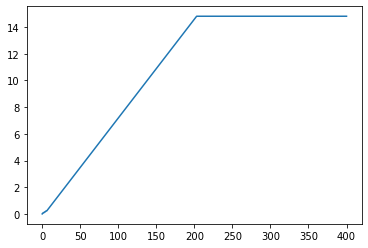

In [98]:
#for this I-TSM, the growth will mainly occur in the first stratum
print(etas[0])
print(means)
print(sel[0,:,:])
print(np.argmin(obj[0,:] < 20)) #print a stopping time
plt.plot(np.log(obj[0,:]))

(0.5, 0.498)
[0.5, 0.6000000000000001]
[[  0.   0.]
 [  1.   0.]
 [  1.   1.]
 [  2.   1.]
 [  2.   2.]
 [  3.   2.]
 [  3.   3.]
 [  3.   4.]
 [  3.   5.]
 [  3.   6.]
 [  3.   7.]
 [  3.   8.]
 [  3.   9.]
 [  3.  10.]
 [  3.  11.]
 [  3.  12.]
 [  3.  13.]
 [  3.  14.]
 [  3.  15.]
 [  3.  16.]
 [  3.  17.]
 [  3.  18.]
 [  3.  19.]
 [  3.  20.]
 [  3.  21.]
 [  3.  22.]
 [  3.  23.]
 [  3.  24.]
 [  3.  25.]
 [  3.  26.]
 [  3.  27.]
 [  3.  28.]
 [  3.  29.]
 [  3.  30.]
 [  3.  31.]
 [  3.  32.]
 [  3.  33.]
 [  3.  34.]
 [  3.  35.]
 [  3.  36.]
 [  3.  37.]
 [  3.  38.]
 [  3.  39.]
 [  3.  40.]
 [  3.  41.]
 [  3.  42.]
 [  3.  43.]
 [  3.  44.]
 [  3.  45.]
 [  3.  46.]
 [  3.  47.]
 [  3.  48.]
 [  3.  49.]
 [  3.  50.]
 [  3.  51.]
 [  3.  52.]
 [  3.  53.]
 [  3.  54.]
 [  3.  55.]
 [  3.  56.]
 [  3.  57.]
 [  3.  58.]
 [  3.  59.]
 [  3.  60.]
 [  3.  61.]
 [  3.  62.]
 [  3.  63.]
 [  3.  64.]
 [  3.  65.]
 [  3.  66.]
 [  3.  67.]
 [  3.  68.]
 [  3.  69.]
 [  3.  70.]

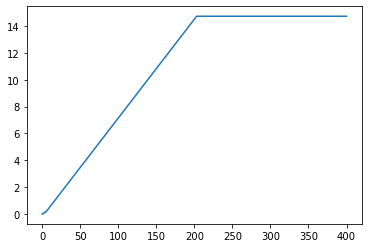

In [94]:
#while for this one the growth is all in the second stratum
print(etas[42])
print(means)
print(sel[42,:,:])
print(np.argmin(obj[0,:] < 20))
plt.plot(np.log(obj[42,:]))

#### Round Robin

In [109]:
#round robin
allocation_func = allocations_dict["round_robin"]
obj = np.zeros((len(etas), np.sum(n) + 1))
sel = np.zeros((len(etas), np.sum(n) + 1, K))
for i in np.arange(len(etas)):
                obj[i,:], sel[i,:,:] = intersection_mart(
                    x = x,
                    N = N,
                    eta = etas[i],
                    lam_func = lam_func,
                    mixing_dist = mixing_dist,
                    allocation_func = allocation_func,
                    combine = combine,
                    theta_func = theta_func,
                    log = log,
                    WOR = WOR,
                    return_selections = True)
opt_index = np.argmin(obj, 0) if combine != "fisher" else np.argmax(obj, 0)
eta_opt = np.zeros((np.sum(n) + 1, len(x)))
mart_opt = np.zeros(np.sum(n) + 1)
global_sample_size = np.sum(np.max(sel, 0), 1)
for i in np.arange(np.sum(n) + 1):
    eta_opt[i,:] = etas[opt_index[i]]
    mart_opt[i] = obj[opt_index[i],i]
st_rr = np.argmax(mart_opt > 20)

In [110]:
st_rr, eta_opt[st_rr] #stopping time and the hardest eta to reject

(84, array([0.4, 0.6]))

In [112]:
opt_index #these are (basically) vertices

array([ 0, 42,  1, 42,  1, 42,  1, 42,  1, 42,  1, 42,  1, 42,  1, 42,  1,
       42,  1, 38,  1, 38,  1, 38,  1, 38,  1, 38,  1, 38,  1, 38,  1, 38,
        1, 38,  1, 38,  1, 38,  1, 38,  1, 38,  1, 38,  1, 38,  1, 38,  1,
       38,  1, 38,  1, 38,  1, 38,  1, 38,  1, 38,  1, 38,  1, 38,  1, 38,
        1, 38,  1, 38,  1, 38,  1, 38,  1, 38,  1, 38,  1, 38,  1, 38,  1,
       38,  1, 38,  1, 38,  1, 38,  1, 38,  1, 38,  1, 38,  1, 38,  1, 38,
        1, 38,  1, 38,  1, 38,  1, 38,  1, 38,  1, 38,  1, 38,  1, 38,  1,
       38,  1, 38,  1, 38,  1, 38,  1, 38,  1, 38,  1, 38,  1, 38,  1, 38,
        1, 38,  1, 38,  1, 38,  1, 38,  1, 38,  1, 38,  1, 38,  1, 38,  1,
       38,  1, 38,  1, 38,  1, 38,  1, 38,  1, 38,  1, 38,  1, 38,  1, 38,
        1, 38,  1, 38,  1, 38,  1, 38,  1, 38,  1, 38,  1, 38,  1, 38,  1,
       38,  1, 38,  1, 38,  1, 38,  1, 38,  1, 38,  1, 38,  1, 38,  1, 38,
        1, 38,  1, 38,  1, 38,  1, 38,  1, 38,  1, 38,  1, 38,  1, 38,  1,
       38,  1, 38,  1, 38

(0.4225, 0.576)
[0.5, 0.6000000000000001]
[[  0.   0.]
 [  1.   0.]
 [  1.   1.]
 [  2.   1.]
 [  2.   2.]
 [  3.   2.]
 [  3.   3.]
 [  4.   3.]
 [  4.   4.]
 [  5.   4.]
 [  5.   5.]
 [  6.   5.]
 [  6.   6.]
 [  7.   6.]
 [  7.   7.]
 [  8.   7.]
 [  8.   8.]
 [  9.   8.]
 [  9.   9.]
 [ 10.   9.]
 [ 10.  10.]
 [ 11.  10.]
 [ 11.  11.]
 [ 12.  11.]
 [ 12.  12.]
 [ 13.  12.]
 [ 13.  13.]
 [ 14.  13.]
 [ 14.  14.]
 [ 15.  14.]
 [ 15.  15.]
 [ 16.  15.]
 [ 16.  16.]
 [ 17.  16.]
 [ 17.  17.]
 [ 18.  17.]
 [ 18.  18.]
 [ 19.  18.]
 [ 19.  19.]
 [ 20.  19.]
 [ 20.  20.]
 [ 21.  20.]
 [ 21.  21.]
 [ 22.  21.]
 [ 22.  22.]
 [ 23.  22.]
 [ 23.  23.]
 [ 24.  23.]
 [ 24.  24.]
 [ 25.  24.]
 [ 25.  25.]
 [ 26.  25.]
 [ 26.  26.]
 [ 27.  26.]
 [ 27.  27.]
 [ 28.  27.]
 [ 28.  28.]
 [ 29.  28.]
 [ 29.  29.]
 [ 30.  29.]
 [ 30.  30.]
 [ 31.  30.]
 [ 31.  31.]
 [ 32.  31.]
 [ 32.  32.]
 [ 33.  32.]
 [ 33.  33.]
 [ 34.  33.]
 [ 34.  34.]
 [ 35.  34.]
 [ 35.  35.]
 [ 36.  35.]
 [ 36.  36.]
 [ 37.  3

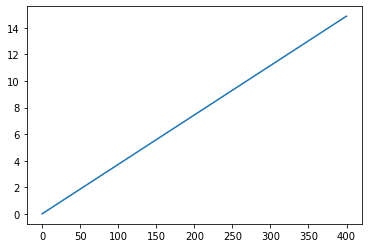

In [70]:
print(etas[10]) #note that our theory says this (or the other vertex) has the largest stopping time
print(means)
print(sel[10,:,:])
plt.plot(np.log(obj[10,:]))
print(np.argmin(obj[10,:] < 20))

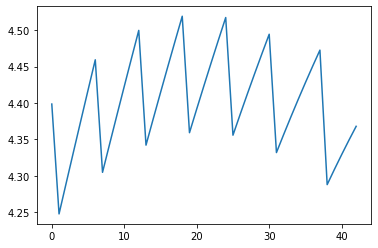

In [90]:
#the objective is curiously ~very~ flat across the range of eta, 
#but recall that the AMGM gives that the minimum is on a vertex
plt.plot(obj[:,40])

In [71]:
means[0] - etas[0][0], means[1] - etas[0][1]

(0.10249999999999998, 1.1102230246251565e-16)

(0.5, 0.498)
[0.5, 0.6000000000000001]
82


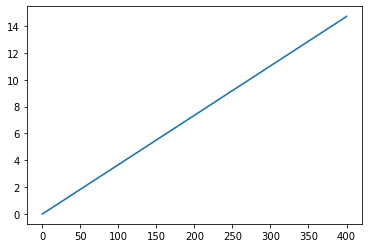

In [57]:
#while for this one the growth is all in the second stratum
print(etas[42])
print(means)
plt.plot(np.log(obj[42,:]))
print(np.argmin(obj[42,:] < 20))

In [6]:
%%time
#run guts of ui_nnsm with greedy allocation
#nb: this takes too long to run right now
K = len(x)
w = N / np.sum(N)
n = [x_k.shape[0] for x_k in x]
obj = np.zeros((len(etas), np.sum(n) + 1))
sel = np.zeros((len(etas), np.sum(n) + 1, K))
#different method for greedy_kelly, since it needs to sequentially update the eta
#is there a way to make this cleaner?
if allocation_func == Allocations.greedy_kelly:
    assert mixture is None, "cannot use greedy_kelly with a mixing distribution"
    #selections from 0 in each stratum; time 1 is first sample
    T_k = np.zeros((np.sum(n) + 1, K), dtype = int)
    running_T_k = np.zeros(K, dtype = int)
    t = 0
    eta_star = np.zeros(K) #intialize eta_star (the minimizer, to be tracked)
    while np.any(running_T_k < n):
        t += 1
        next_k = Allocations.greedy_kelly(x, running_T_k, n, N, eta_star, lam_func)
        running_T_k[next_k] += 1
        T_k[t,:] = running_T_k
        for i in np.arange(len(etas)):
            #time these lines, is your processing of intersection mart increasing as T_k increases
            obj[i,t] = intersection_mart(x = x, N = N, eta = etas[i], T_k = T_k[0:(t+1),:],
                lam_func = lam_func, combine = combine, theta_func = theta_func, log = log, WOR = WOR)[-1]
        eta_star = etas[np.argmin(obj[:,t])] if combine != "fisher" else np.argmax(obj, 0)
# if allocation_func in nonadaptive_allocations:
#     T_k = sel[0,:,:]
# else:
#     T_k = None
opt_index = np.argmin(obj, 0) if combine != "fisher" else np.argmax(obj, 0)
eta_opt = np.zeros((np.sum(n) + 1, len(x)))
mart_opt = np.zeros(np.sum(n) + 1)
global_sample_size = np.sum(np.max(sel, 0), 1)
for i in np.arange(np.sum(n) + 1):
    eta_opt[i,:] = etas[opt_index[i]]
    mart_opt[i] = obj[opt_index[i],i]

NameError: name 'theta_func' is not defined

In [5]:
#why does this return 0 in the first index?
%%time
union_intersection_mart(
                        x = x,
                        N = N,
                        etas = etas,
                        lam_func = bets_dict[bet],
                        allocation_func = Allocations.greedy_kelly,
                        combine = "product",
                        log = False,
                        WOR = False)

CPU times: user 25 s, sys: 107 ms, total: 25.1 s
Wall time: 25.1 s


(array([0.00000000e+00, 1.00000000e+00, 1.09590827e+00, 1.09590827e+00,
        1.18361183e+00, 1.18414080e+00, 1.28859512e+00, 1.33521879e+00,
        1.40910874e+00, 1.46889731e+00, 1.54515177e+00, 1.61709690e+00,
        1.69752683e+00, 1.78011935e+00, 1.86748424e+00, 1.96069650e+00,
        2.05659519e+00, 2.16127762e+00, 2.26670598e+00, 2.38384670e+00,
        2.49992654e+00, 2.63064802e+00, 2.75863619e+00, 2.90419777e+00,
        3.04549933e+00, 3.20730351e+00, 3.36348792e+00, 3.54308943e+00,
        3.71590946e+00, 3.91502649e+00, 4.10643970e+00, 4.32696715e+00,
        4.53916014e+00, 4.78318466e+00, 5.01744717e+00, 5.28841705e+00,
        5.54333663e+00, 5.84791642e+00, 6.12532084e+00, 6.46750359e+00,
        6.76937785e+00, 7.15258479e+00, 7.33896514e+00, 7.90627934e+00,
        8.11872521e+00, 8.74037128e+00, 8.98223723e+00, 9.66344828e+00,
        9.93850799e+00, 1.06850193e+01, 1.09975166e+01, 1.18156134e+01,
        1.21703196e+01, 1.30668889e+01, 1.34691666e+01, 1.445175

In [43]:
#Gaussian
K = 5
N = [100 for _ in range(K)]
x = [random_truncated_gaussian(0.8, 0.05, N[k]) for k in range (K)]
#point mass
delta = 0.5
means = [alt - 0.5*delta, alt + 0.5*delta]
K = 2
N = [200, 200]
x = [np.ones(N[0]) * means[0], np.ones(N[1]) * means[1]]


max_iterations = 1000
n = [x[k].shape[0] for k in range(K)]
#define constraint set for pypoman projection
A = np.concatenate((
    np.expand_dims(w, axis = 0),
    #np.expand_dims(-w, axis = 0), project to halfspace; gradient should always point towards boundary anyway
    -np.identity(K),
    np.identity(K)))
b = np.concatenate((eta_0 * np.ones(1), np.zeros(K), np.ones(K)))
proj = lambda eta: pypoman.projection.project_point_to_polytope(point = eta, ineq = (A, b))
#TODO: pick a good value for delta, which dampens the Newton step.
#could also choose through learn by backtracking line search
delta = 1

#this is a nested list of arrays
#it stores the samples available in each stratum at time i = 0,1,2,...,n
samples_t = [[[] for _ in range(K)] for _ in range(np.sum(n))]
#initialize with no samples
uinnsms = [1] #uinnsm starts at 1 at time 0
samples_t[0] = [np.array([]) for _ in range(K)] #initialize with no samples
T_k = np.zeros((np.sum(n), K), dtype = int)
eta_stars = np.zeros((np.sum(n), K))

for i in np.arange(1, np.sum(n)):
    #select next stratum
    S_i = allocation_func(x, T_k[i-1,:], n, N, eta = eta_stars[i-1], lam_func = Bets.smooth_predictable)
    T_k[i,:] = T_k[i-1,:]
    T_k[i,S_i] += 1
    for k in np.arange(K):
        samples_t[i][k] = x[k][np.arange(T_k[i,k])] #update available samples
    #initial estimate of minimum by projecting current sample mean onto null space
    if any(T_k[i,:] == 0):
        sample_means = np.array([eta_0 for _ in range(K)])
    else:
        sample_means = np.array([np.mean(samples_t[i][k]) for k in range(K)])
    eta_l = proj(sample_means)
    step_size = 1
    counter = 0
    #find optimum
    #while step_size > 1e-4:
    print(proj(grad_l))
    while np.linalg.norm(grad_l) > 1e-4:
        counter += 1
        if counter == max_iterations:
            raise Exception("Gradient descent took too many steps to converge. Raise max_iterations, or check conditioning of the optimization problem.")
        grad_l = PGD.grad(samples_t[i], eta_l)
        hess_l = PGD.hessian(samples_t[i], eta_l)
        print(grad_l)
        #take dampened Newton step and then project onto null
        next_eta = proj(eta_l - (delta/hess_l) * grad_l)
        step_size = PGD.global_log_mart(samples_t[i], eta_l) - PGD.global_log_mart(samples_t[i], next_eta)
        eta_l = next_eta

    eta_stars[i] = eta_l
    #store current value of UI-TS
    log_ts = PGD.global_log_mart(samples_t[i], eta_stars[i])
    if log:
        uinnsms.append(log_ts)
    else:
        uinnsms.append(np.exp(log_ts))

[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]


In [40]:
eta_stars

array([[0.  , 0.  ],
       [0.5 , 0.5 ],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.25,

In [18]:
for alt, delta, method, bet, allocation in itertools.product(alt_grid, delta_grid, methods_list, bets_list, allocations_list):
    means = [alt - 0.5*delta, alt + 0.5*delta]
    calX = [np.array([0, means[0]]),np.array([0, means[1]])]
    samples = [np.ones(N[0]) * means[0], np.ones(N[1]) * means[1]]
    eta_grid, calC, ub_calC = construct_eta_grid(eta_0, calX, N)


    if method == 'lcb':
        min_eta = None
        if bet == 'uniform_mixture' or allocation in ['proportional_to_mart','predictable_kelly','minimax']:
            stopping_time = None
        else:
            lower_bound = global_lower_bound(
                x = samples,
                N = N,
                lam_func = bets_dict[bet],
                allocation_func = allocations_dict[allocation],
                alpha = alpha,
                breaks = 1000,
                WOR = False)
            stopping_time = np.where(any(lower_bound > eta_0), np.argmax(lower_bound > eta_0), np.sum(N))
            min_eta = None
    elif method == 'uinnsm_product':
        if allocation == 'minimax':
            if bet == 'smooth_predictable':
                ui_mart_minimax, min_etas_minimax, T_k_minimax = negexp_ui_mart(samples, N, Allocations.predictable_kelly, log = False)
                stopping_time = np.where(any(ui_mart_minimax > 1/alpha), np.argmax(ui_mart_minimax > 1/alpha), np.sum(N))
                min_eta = min_etas_minimax[stopping_time]
            else:
                stopping_time = None
                min_eta = None
        else:
            ui_mart_rr, min_etas_rr, global_ss_rr, T_k_rr = union_intersection_mart(
                        x = samples,
                        N = N,
                        etas = eta_grid,
                        lam_func = bets_dict[bet],
                        allocation_func = allocations_dict[allocation],
                        combine = "product",
                        log = False,
                        WOR = False)
            pval = np.minimum(1, 1/ui_mart_rr)
            stopping_time = np.where(any(ui_mart_rr > 1/alpha), np.argmax(ui_mart_rr > 1/alpha), np.sum(N))
            min_eta = min_etas_rr[stopping_time]
    elif method == 'uinnsm_fisher' and allocation != 'minimax':
        pval, min_etas, global_ss, T_k = union_intersection_mart(
                    x = samples,
                    N = N,
                    etas = eta_grid,
                    lam_func = bets_dict[bet],
                    allocation_func = allocations_dict[allocation],
                    combine = "fisher",
                    log = False,
                    WOR = False)
        stopping_time = np.where(any(pval < alpha), np.argmax(pval < alpha), np.sum(N))
        min_eta = min_etas[stopping_time]
    #instead of recording stopping times, we record the P-value at every time
    # for i in range(pval.shape[0]):
    #     data_dict = {
    #         "alt":alt,
    #         "delta":delta,
    #         "method":str(method),
    #         "bet":str(bet),
    #         "allocation":str(allocation),
    #         "time": i + 1,
    #         "pval": pval[i],
    #         "min_eta_1": min_eta[i,0]
    #         }
    data_dict = {
        "alt":alt,
        "delta":delta,
        "method":str(method),
        "bet":str(bet),
        "allocation":str(allocation),
        "stopping_time":stopping_time,
        "worst_case_eta":min_eta}
    results.append(data_dict)
results = pd.DataFrame(results)

AttributeError: type object 'Allocations' has no attribute 'greedy_kelly'

In [11]:
ui_mart_rr[10], ui_mart_minimax[10]

(9.147406208009434, 11.039153585394756)

In [12]:
min_etas_rr[10,:], min_etas_minimax[10,:]

(array([0.365, 0.635]), array([0.23638651, 0.76361349]))

In [13]:
T_k_rr[10,:], T_k_minimax[10,:]

(array([5., 5.]), array([7, 3]))

In [14]:
x = samples
etas = eta_grid
lam_func = Bets.smooth_predictable
#lam_func = Bets.fixed
mixture = None
allocation_func = Allocations.round_robin
combine = "product"
theta_func = None
log = False
WOR = False 
nonadaptive_allocations = [Allocations.round_robin, Allocations.proportional_round_robin, Allocations.neyman, Allocations.more_to_larger_means]

assert (lam_func is None) or (mixture is None), "cannot specify both a mixture strategy and predictable lambda function"
K = len(x)
w = N / np.sum(N)
if mixture == "vertex":
    vertices = construct_vertex_etas(eta_0_mixture, N)
    mixing_dist = 1 - np.array(vertices)
elif mixture == "uniform":
    lam_grids = K * [np.linspace(0.01,0.99,10)]
    mixing_dist = np.array(list(itertools.product(*lam_grids)))
elif mixture is None:
    mixing_dist = None
else:
    stop("Specify a valid mixture method; either uniform or vertex")
#evaluate intersection mart on every eta
obj = np.zeros((len(etas), np.sum(N) + 1))
sel = np.zeros((len(etas), np.sum(N) + 1, K))
for i in np.arange(len(etas)):
    obj[i,:], sel[i,:,:] = intersection_mart(
        x = x,
        N = N,
        eta = etas[i],
        lam_func = lam_func,
        mixing_dist = mixing_dist,
        allocation_func = allocation_func,
        combine = combine,
        theta_func = theta_func,
        log = log,
        WOR = WOR,
        return_selections = True)
#return the global selections if nonadaptive; otherwise return None
if allocation_func in nonadaptive_allocations:
    T_k = sel[0,:,:]
else:
    T_k = None
opt_index = np.argmin(obj, 0) if combine != "fisher" else np.argmax(obj, 0)
eta_opt = np.zeros((np.sum(N) + 1, len(x)))
mart_opt = np.zeros(np.sum(N) + 1)
global_sample_size = np.sum(np.max(sel, 0), 1)
for i in np.arange(np.sum(N) + 1):
    eta_opt[i,:] = etas[opt_index[i]]
    mart_opt[i] = obj[opt_index[i],i]

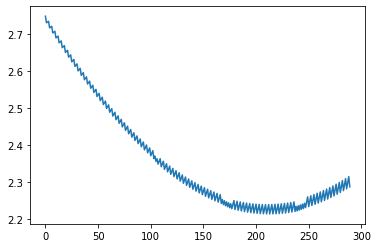

In [7]:
plt.plot(np.log(obj[:,10]))

In [2]:
alpha = 0.05
eta_0 = 1/2
reps = 1 #sort of deprecated. Repetions now occur in parallel, through SLURM
#sim_rep = os.getenv('SLURM_ARRAY_TASK_ID')
sim_rep = 2
np.random.seed(int(sim_rep)) #this sets a different seed for every rep


K_grid = [2]
#global_mean_grid = np.linspace(0.5, 0.7, 10)
global_mean_grid = [0.5]
delta_grid = [0] #maximum spread of the stratum means
sd_grid = [0.05]

results = []
for K, global_mean, delta, sd in itertools.product(K_grid, global_mean_grid, delta_grid, sd_grid):
    shifts = np.linspace(-0.5,0.5,K)
    deltas = shifts * delta
    N = [int(1000/K) for _ in range(K)]
    w = N/np.sum(N)
    etas = construct_vertex_etas(N = N, eta_0 = eta_0)


    x = [random_truncated_gaussian(mean = global_mean + deltas[k], sd = sd, size = N[k]) for k in range(K)]
    #unstratified sample by mixing
    x_unstrat = np.zeros(np.sum(N))
    for i in range(np.sum(N)):
        rand_k =  np.random.choice(np.arange(K), size = 1, p = w)
        x_unstrat[i] = random_truncated_gaussian(mean = global_mean + deltas[rand_k], sd = sd, size = 1)

    unstrat_fixed = mart(x_unstrat, eta = 0.5, lam_func = Bets.fixed, log = True)
    unstrat_agrapa = mart(x_unstrat, eta = 0.5, lam_func = Bets.agrapa, log = True)
    lcb_fixed = global_lower_bound(x, N, Bets.fixed, Allocations.proportional_round_robin, alpha = 0.05, WOR = False, breaks = 1000)
    lcb_agrapa = global_lower_bound(x, N, Bets.agrapa, Allocations.proportional_round_robin, alpha = 0.05, WOR = False, breaks = 1000)
    uinnsm_fixed = union_intersection_mart(x, N, etas, Bets.fixed, Allocations.proportional_round_robin, WOR = False, combine = "product", log = True)[0]
    uinnsm_smooth = negexp_ui_mart(x, N, Allocations.proportional_round_robin, log = True)[0]
    uinnsm_smooth_minimax = negexp_ui_mart(x, N, Allocations.predictable_kelly, log = True)[0]

    stop_unstrat_fixed = np.where(any(unstrat_fixed > -np.log(alpha)), np.argmax(unstrat_fixed > -np.log(alpha)), np.sum(N))
    stop_unstrat_agrapa = np.where(any(unstrat_agrapa > -np.log(alpha)), np.argmax(unstrat_agrapa > -np.log(alpha)), np.sum(N))
    stop_lcb_agrapa = np.where(any(lcb_agrapa > eta_0), np.argmax(lcb_agrapa > eta_0), np.sum(N))
    stop_lcb_fixed = np.where(any(lcb_fixed > eta_0), np.argmax(lcb_fixed > eta_0), np.sum(N))
    stop_uinnsm_fixed = np.where(any(uinnsm_fixed > -np.log(alpha)), np.argmax(uinnsm_fixed > -np.log(alpha)), np.sum(N))
    stop_uinnsm_smooth = np.where(any(uinnsm_smooth > -np.log(alpha)), np.argmax(uinnsm_smooth > -np.log(alpha)), np.sum(N))
    stop_uinnsm_smooth_minimax = np.where(any(uinnsm_smooth_minimax > -np.log(alpha)), np.argmax(uinnsm_smooth_minimax > -np.log(alpha)), np.sum(N))

    results_dict = {
        "K":K,
        "global_mean":global_mean,
        "delta":delta,
        "sd":sd,
        "rep":sim_rep,
        "stop_unstrat_fixed":stop_unstrat_fixed,
        "stop_unstrat_agrapa":stop_unstrat_agrapa,
        "stop_lcb_fixed":stop_lcb_fixed,
        "stop_lcb_agrapa":stop_lcb_agrapa,
        "stop_uinnsm_fixed":stop_uinnsm_fixed,
        "stop_uinnsm_smooth":stop_uinnsm_smooth,
        "stop_uinnsm_smooth_minimax":stop_uinnsm_smooth_minimax
    }
    results.append(results_dict)
results = pd.DataFrame(results)

/Users/Jake/Dropbox/RLAs/UI-NNSMs/Code/utils.py:74: RuntimeWarning: divide by zero encountered in true_divide
  lam_trunc = np.maximum(0, np.minimum(lam_untrunc, c/eta))


In [41]:
max_iterations = 1000

allocation_func = Allocations.predictable_kelly
#allocation_func = Allocations.proportional_round_robin

log = True
w = N / np.sum(N) #stratum weights
K = len(N) #number of strata
n = [x[k].shape[0] for k in range(K)]    
global_mean = 0.5
deltas = [-0.4,0.4]
x = [random_truncated_gaussian(mean = global_mean + deltas[k], sd = sd, size = N[k]) for k in range(K)]

#define constraint set for pypoman projection
A = np.concatenate((
    np.expand_dims(w, axis = 0),
    np.expand_dims(-w, axis = 0),
    -np.identity(K),
    np.identity(K)))
b = np.concatenate((eta_0 * np.ones(2), np.zeros(K), np.ones(K)))
proj = lambda eta: pypoman.projection.project_point_to_polytope(point = eta, ineq = (A, b))
delta = 0.5 #dampening parameter

#this is a nested list of arrays
#it stores the samples available in each stratum at time i = 0,1,2,...,n
samples_t = [[[] for _ in range(K)] for _ in range(np.sum(n))]
#initialize with no samples
uinnsms = [0] if log else 1 #uinnsm starts at 1 at time 0
samples_t[0] = [np.array([]) for _ in range(K)] #initialize with no samples
T_k = np.zeros((np.sum(n), K), dtype = int)
eta_stars = np.zeros((np.sum(n), K))

for i in np.arange(1, np.sum(n)-1):
    #select next stratum
    S_i = allocation_func(x, T_k[i-1,:], n, N, eta = eta_stars[i-1], lam_func = Bets.smooth_predictable)
    T_k[i,:] = T_k[i-1,:]
    T_k[i,S_i] += 1
    for k in np.arange(K):
        samples_t[i][k] = x[k][np.arange(T_k[i,k])] #update available samples
    #initial estimate of minimum by projecting current sample mean onto null space
    if any(T_k[i,:] == 0):
        sample_means = np.array([eta_0 for _ in range(K)])
    else:
        sample_means = np.array([np.mean(samples_t[i][k]) for k in range(K)])
    eta_l = proj(sample_means)
    #eta_l = np.array([0.5,0.5])
    #eta_l = np.array([0.1,0.9])
    step_size = 1
    counter = 0
    etas = eta_l
    objs = 0
    grad_l = np.ones(K)
    grads = grad_l
    print(samples_t[i])
    #find optimum
    #while step_size > 1e-5:
    while np.linalg.norm(grad_l) > 0.01:
        counter += 1
        if counter == max_iterations:
            raise Exception("Gradient descent took too many steps to converge. Raise max_iterations, or check conditioning of the optimization problem.")
        grad_l = PGD.grad(samples_t[i], eta_l)
        hess_l = PGD.hessian(samples_t[i], eta_l)
        #take dampened Newton step and then project onto null
        next_eta = proj(eta_l - (delta/hess_l) * grad_l)
        step_size = PGD.global_log_mart(samples_t[i], eta_l) - PGD.global_log_mart(samples_t[i], next_eta)
        eta_l = next_eta
        etas = np.vstack([etas, eta_l])
        grads = np.vstack([grads, grad_l])
        objs = np.vstack([objs, PGD.global_log_mart(samples_t[i], next_eta)])
#         if counter > 50: 
#             break 
#     if counter > 50:
#         break
    eta_stars[i] = eta_l
    #store current value of UI-TS
    log_ts = PGD.global_log_mart(samples_t[i], eta_stars[i])
    if log:
        uinnsms.append(log_ts)
    else:
        uinnsms.append(np.exp(log_ts))

[array([0.06907565]), array([], dtype=float64)]


Exception: Gradient descent took too many steps to converge. Raise max_iterations, or check conditioning of the optimization problem.

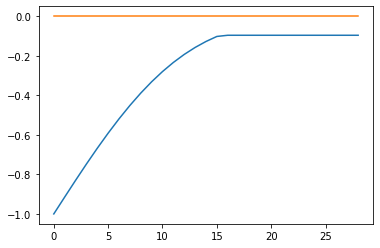

In [43]:
plt.plot(grads[1:30,:])

In [36]:
T_k[i,:]

array([1, 0])

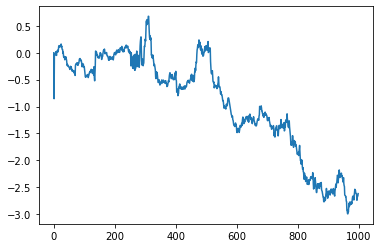

In [13]:
#plot uinnsms over sampling time
plt.plot(uinnsms)

In [14]:
eta_l - (1/hess_l) * grad_l

array([0.43607291, 1.22915136])

In [15]:
#it seems like the problem is that the optimization can become very poorly conditioned 
#in particular if the sample sizes are highly imbalanced, or if 
proj(eta_l - (delta/hess_l) * grad_l)

array([0.10378654, 0.89621346])

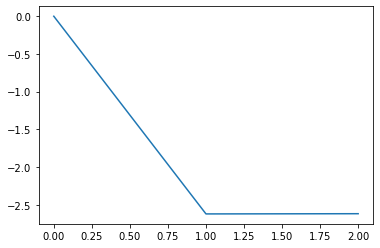

In [21]:
#plot objective over PGD steps
plt.plot(objs)

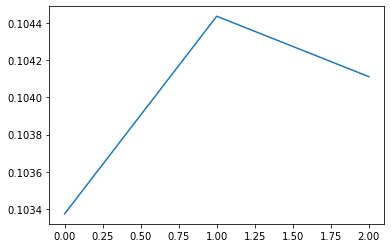

In [20]:
#plot eta over PGD steps
plt.plot(etas[:,0])

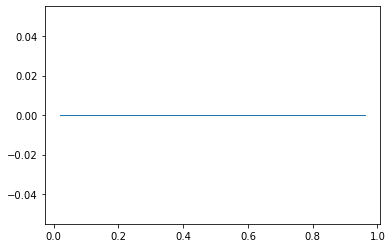

minimum eta = [0.02 0.98]


In [39]:
plot_marts_eta(x = samples_t[2],
               N = N, 
               lam_func = Bets.smooth_predictable, 
               allocation_func = Allocations.predictable_kelly,
               combine = "product",
               res = 2e-2,
               range = [0,1])